# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

Joseph Griffith

# Overview - 
These functions implement reinforcement learning on the Towers of Hanoi puzzle, effectiveness of which is controlled with the repetitions, learning rate ('rho'), and epsilon decay factor arguments.

The training function will repeatedly solve the puzzle, initially making random moves, but gradually transitioning to moves chosen based on it's previous experience.

# Functions - 

Returns a dictionary with keys 0-n, where 0 is the peg ascii, and 1-n are the discs of appropriate size

In [1]:
def makePieces(n):
    pieces = {}
    width = 2*n-1
    length = 2*n-1
    for i in reversed(range(n+1)):
        string = '='*length if i > 0 else '|'
        while len(string) < width:
            string = ' ' + string + ' '
        length = length-2 if length > 1 else 0
        pieces[i] = string
        #print(i, width, length, width-length)        
    for i in range(1, n+1):
        pieces[i] = '\033[1m' + pieces[i] + '\033[0m'
    return pieces

Returns an ascii list version of the puzzle state for printing

In [2]:
def stateToASCII(state, n=3):
    piece = makePieces(n)
    snapshot = [[], [], []]
    for i in range(3):   #number of pegs - doesnt change
        if state[i]:     #peg not empty
            for j in range(len(state[i])):
                snapshot[i].append(piece[state[i][j]])
        while len(snapshot[i]) < n:
                snapshot[i].insert(0, piece[0])
    return snapshot

Returns the number of discs in a puzzle state

In [3]:
def findN(state):
    n = 0
    for i in range(len(state)):
        n += len(state[i])
    return n

Prints out an ascii representation of the puzzle state

In [4]:
#will print invalid states
def printState(state):
    n = findN(state)
    n = n if n >= 3 else 3
    snapshot = stateToASCII(state, n)
    out = ''
    pad = [out for i in range(n)]   # <expression> for <variable> in <collection> 
    while len(snapshot) < n:
        snapshot.append(pad)
    for i in range(n):
        lastrow = len(snapshot[i])-1
        und = '\033[4m' if i == lastrow else ''
        #out = out + '\033[4m'
        for j in range(n):
            out += und + ' ' + snapshot[j][i] + und + ' ' if j < 4 else ''
        out = out + '\033[0m' if i == lastrow else out
        out = out + '\n' if i != len(snapshot)-1 else out
    print(out, '\n')   

Prints all the puzzle states in a solution path

In [5]:
def pathPrint(path):
    print('solution length:', len(path))
    for i in path:
        printState(i)

Returns a list of valid moves from the given puzzle state

In [6]:
def validMoves(state):
    #pegStates = [ [1,2,3], [2,3], [3], [1,3], [1,2], [2], [] ]   #for hanoi(3)
    moves = []
    if state[0]:   #adds moves available from the first peg
        moves.append([1, 2]) if not state[1] or (state[1] and state[0][0] < state[1][0]) else moves
        moves.append([1, 3]) if not state[2] or (state[2] and state[0][0] < state[2][0]) else moves
    if state[1]:   #adds moves available from the second peg
        moves.append([2, 3]) if not state[2] or (state[2] and state[1][0] < state[2][0]) else moves
        moves.append([2, 1]) if not state[0] or (state[0] and state[1][0] < state[0][0]) else moves
    if state[2]:   #adds moves available from the third peg
        moves.append([3, 1]) if not state[0] or (state[0] and state[2][0] < state[0][0]) else moves
        moves.append([3, 2]) if not state[1] or (state[1] and state[2][0] < state[1][0]) else moves 
    return moves

In [7]:
from copy import deepcopy as deep

Returns the resulting puzzle state from a state/move pair, or the original state, if the move is invalid

In [8]:
def makeMove(state, move):
    if validMoves(state).count(move) > 0:
        new = deep(state)
        new[move[1]-1].insert(0, new[move[0]-1].pop(0))
        return new
    print ('Move ', move, ' is not a valid move from state ', state)
    return state

In [9]:
#solving for other sizes does not require different functions
printState_4disk = printState
validMoves_4disk = validMoves
makeMove_4disk = makeMove

Returns either a random move, or the 'greedy' (best known) move for a puzzle state, based on the supplied epsilon

In [10]:
#adapted from code supplied in class
def epsilonGreedy(epsilon, Q, state):
    valid = validMoves(state)
    if np.random.uniform() < epsilon:						# Random Move        
        return valid[np.random.choice(range(len(valid)))]
    else:													# Greedy Move        
        #constructs array of Q values, which is 0 if the state/move key isnt in Q
        #list comprehensions: [ <expression> for <variable> in <collection> (and <var2> in <coll2> ...) (if <condition> (and <condition> ...)) ]
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in valid])
        return valid[ np.argmax(Qs) ]

Returns the start and end states for a hanoi puzzle of the given number of discs

In [11]:
def makePuzzle(n):
    stack = []
    for i in range(n):
        stack.append(i+1)
    return [stack, [], []], [[], [], stack]

Returns the given puzzle state/move pair as a tuple suitable as a dictionary key

In [12]:
def stateMoveTuple(state, move):
    return (stateTuple(state), tuple(move))

Returns a puzzle state that has been converted to a tuple

In [13]:
def stateTuple(state):
    out = []
    for i in range(len(state)):
         out.append(tuple(state[i]))
    return tuple(out)

In [14]:
import numpy as np

**trainQ()** - constructs a Q dictionary with negative 'distances' to Hanoi puzzle goal state
<br>**Arguments** - 
* nRepetitions - the number of times the function will solve the puzzle
* rho - the learning rate 
* epsilonDecayFactor - rate at which the program will shift from random to learned move choices
* validMovesF - a function that returns the valid moves at a puzzle state
* makeMoveF - a function that returns a puzzle state when given a state and move
* n - an optional argument for the number of discs in the puzzle; default is 3
<br>**Returns** - Returns Q and list of the number of steps to reach goal for each repetition.

In [40]:
#adapted from code supplied in class
def trainQ(nRepetitions, rho, epsilonDecayFactor, validMovesF, makeMoveF, n=3):
    rho = 0.2						#learning rate
    epsilon = 1.0					#chance of taking a random action
    epsilons = np.zeros(nRepetitions)		#keeping the epsilons to plot?
    Q = {}									#expected value of future reinforcements
    steps = []
    
    for gamenum in range(nRepetitions):
        epsilon *= epsilonDecayFactor				#decay epsilon
        #epsilons[gamenum] = epsilon					#store each epsilon for plotting
        step = 0									#skip first move
        state, goal = makePuzzle(n)
        done = False
        r = -1										#reinforcement value
        
        while not done:        
            step += 1

            move = epsilonGreedy(epsilon, Q, state)			#chooses random move, or 'best', depending on epsilon
            newstate = makeMoveF(state, move)
            key = stateMoveTuple(state, move)

            if newstate == goal:
                #r = 0
                done = True

            if key not in Q:
                Q[key] = 0

            if step > 1 and not done:
                oldkey = stateMoveTuple(oldstate, oldmove)

                TDE = r + Q[key] - Q[oldkey]
                Q[oldkey] += rho*(TDE)
            elif done:
                Q[oldkey] += rho*(r - Q[oldkey])

            oldstate = state
            oldmove = move
            state = newstate

        steps.append(step)
    return Q, steps    

**testQ()** - constructs a greedy path from the Q given dictionary
<br>**Arguments** - 
* Q - a dictionary with (state, move) tuple keys and number values ranging from (-infinity, 0]
* maxSteps - the maximum length of the path that will be constructed
* validMovesF - a function that returns the valid moves at a puzzle state
* makeMoveF - a function that returns a puzzle state when given a state and move
* n - an optional argument for the number of discs in the puzzle; default is 3
<br>**Returns** - a list of states that make up the constructed path

In [41]:
def testQ(Q, maxSteps, validMovesF, makeMoveF, n=3):
    path = []
    state, goal = makePuzzle(n)
    path.append(state)
    i = 1
    while state != goal and i < maxSteps:
        move = epsilonGreedy(-9999, Q, state)
        state = makeMove(state, move)
        path.append(state)
        i += 1
    return path

# Testing Sandbox - 

In [49]:
#hanoi(3)
Q, stepsToGoal = trainQ(50, 0.65, 0.9, validMoves, makeMove)
print(len(Q), stepsToGoal)
print(Q.values())
Q, stepsToGoal = trainQ(3000, 0.65, 0.9, validMoves, makeMove)
path = testQ(Q, 20, validMoves, makeMove)
print(Q.values())   #strongly tied to learning/decay rate - will go up a lot if those are slower... 
pathPrint(path)

76 [87, 95, 79, 197, 191, 14, 43, 52, 12, 11, 36, 17, 14, 28, 22, 9, 42, 10, 41, 13, 11, 16, 8, 9, 23, 13, 23, 7, 26, 7, 7, 9, 7, 9, 12, 8, 7, 29, 7, 7, 8, 7, 7, 7, 7, 10, 7, 7, 7, 7]
dict_values([-5.316163133346099, -4.734113086170433, -4.440534717467031, -4.71561752769301, -4.228099609650726, -3.72258663977758, -3.899519615478354, -4.218104699835312, -4.18171551099092, -4.626156397236546, -4.335654777486227, -3.33961897481796, -2.3372313155349222, -2.134309255791728, -2.496996216320229, -3.1872608846706485, -3.4098575042834094, -2.6124299079030724, -3.3909511066623677, -4.616690322943214, -5.3004152978360075, -3.4727453904420966, -3.224395625675042, -3.8873305442268578, -3.844574401497906, -3.4705921274056974, -3.292408848094368, -3.5821363848083805, -3.7299954020163852, -3.7621296993810223, -1.6958639109993137, -1.5535446308784386, -1.3362456714831206, -1.6847565143523981, -1.6472301867469321, -1.59156055146496, -1.52345571968811, -1.0363623227392, -1.2721870351695286, -1.3940707262

4 disc puzzle

In [22]:
#hanoi(4)
Q, stepsToGoal4 = trainQ(300, 0.75, 0.99, validMoves, makeMove, 4)
print(len(Q), stepsToGoal4)
path = testQ(Q, 20, validMoves, makeMove, 4)
pathPrint(path)

238 [1342, 185, 822, 1166, 315, 267, 1693, 355, 516, 81, 125, 192, 103, 313, 677, 68, 282, 398, 255, 322, 291, 47, 139, 183, 131, 193, 32, 50, 82, 120, 58, 182, 89, 79, 108, 80, 99, 104, 114, 68, 75, 130, 75, 65, 29, 55, 79, 149, 168, 140, 98, 87, 28, 165, 214, 21, 97, 52, 23, 76, 24, 50, 59, 85, 51, 107, 36, 40, 57, 36, 27, 30, 82, 108, 26, 103, 48, 37, 38, 35, 42, 68, 24, 32, 25, 33, 59, 36, 39, 65, 20, 73, 27, 74, 28, 37, 25, 69, 27, 34, 27, 28, 27, 23, 26, 26, 48, 36, 21, 22, 48, 69, 38, 18, 27, 29, 24, 17, 20, 19, 27, 79, 64, 47, 45, 24, 18, 23, 15, 22, 20, 19, 19, 23, 87, 61, 25, 80, 65, 23, 62, 31, 20, 36, 20, 16, 21, 29, 15, 23, 24, 23, 19, 40, 20, 42, 18, 16, 20, 18, 15, 32, 19, 15, 22, 19, 19, 15, 16, 21, 33, 19, 22, 20, 75, 80, 38, 28, 57, 19, 15, 15, 17, 16, 17, 19, 16, 16, 15, 21, 17, 15, 19, 20, 15, 16, 17, 17, 21, 26, 15, 16, 23, 15, 15, 21, 17, 15, 15, 15, 18, 15, 15, 15, 16, 22, 19, 17, 15, 17, 15, 17, 18, 15, 17, 17, 15, 17, 15, 19, 17, 15, 16, 15, 16, 26, 17, 18, 15,

5 disc puzzle

In [23]:
Q, stepsToGoal5 = trainQ(300, 0.75, 0.99, validMoves, makeMove, 5)
print(len(Q), stepsToGoal5)
path = testQ(Q, 32, validMoves, makeMove, 5)
pathPrint(path)

724 [1724, 4935, 2076, 8100, 7107, 4479, 1913, 1800, 734, 3286, 1190, 1824, 600, 642, 131, 533, 633, 701, 368, 647, 847, 397, 506, 373, 1168, 728, 1324, 324, 424, 353, 351, 714, 555, 458, 531, 492, 268, 356, 431, 808, 259, 335, 588, 452, 72, 156, 299, 239, 384, 134, 381, 129, 382, 121, 138, 152, 225, 197, 289, 108, 364, 282, 118, 756, 89, 137, 106, 215, 145, 283, 171, 130, 286, 100, 120, 176, 99, 62, 189, 88, 469, 76, 93, 398, 152, 101, 338, 133, 117, 183, 81, 90, 105, 100, 106, 125, 148, 89, 143, 236, 111, 76, 205, 236, 43, 160, 81, 174, 75, 127, 266, 76, 110, 119, 64, 105, 93, 172, 67, 143, 96, 52, 168, 140, 170, 65, 92, 343, 178, 102, 53, 64, 124, 44, 368, 277, 66, 76, 320, 52, 46, 167, 85, 70, 242, 85, 161, 41, 77, 62, 65, 103, 255, 82, 167, 49, 82, 58, 59, 300, 123, 67, 149, 61, 61, 58, 82, 79, 159, 58, 60, 229, 45, 268, 59, 235, 79, 261, 39, 227, 144, 68, 250, 45, 63, 44, 67, 296, 99, 41, 122, 53, 51, 119, 262, 41, 125, 41, 55, 162, 42, 40, 119, 72, 45, 150, 53, 57, 136, 39, 34, 

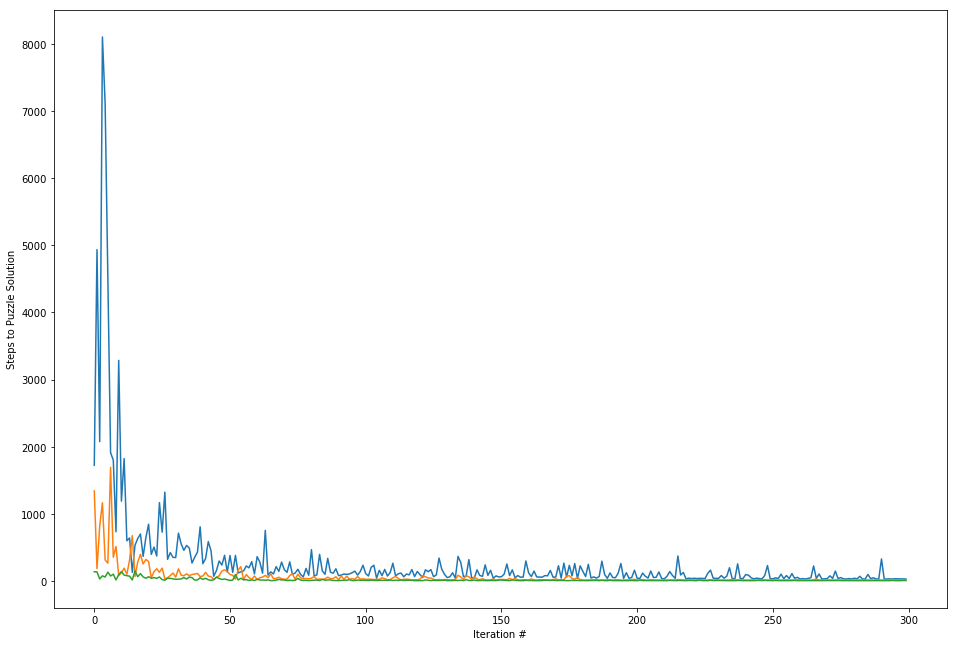

In [24]:
import matplotlib.pyplot as plot
%matplotlib inline
plot.figure(figsize=(16,11))
plot.plot(stepsToGoal5, '-');
plot.plot(stepsToGoal4, '-');
plot.plot(stepsToGoal, '-');
plot.ylabel('Steps to Puzzle Solution')
plot.xlabel('Iteration #'); #; supresses printing unwanted nonsense

In [25]:
n = 6
for i in range(1, n+1):
    #print('len(s):', len(s), ', len(s)//2:', len(s)//2, ', i:', i, ', len//2+i:', len(s)//2+i)
    print('n:', n, ', i*2-1:', i*2-1, ', i:', i)    

n: 6 , i*2-1: 1 , i: 1
n: 6 , i*2-1: 3 , i: 2
n: 6 , i*2-1: 5 , i: 3
n: 6 , i*2-1: 7 , i: 4
n: 6 , i*2-1: 9 , i: 5
n: 6 , i*2-1: 11 , i: 6


In [26]:
s, g = makePuzzle(6)
print(s)
print(g)

[[1, 2, 3, 4, 5, 6], [], []]
[[], [], [1, 2, 3, 4, 5, 6]]


In [27]:
check = [[4, 5], [1], [2, 3]]
findN(check)

5

In [28]:
printState(s)
printState(g)

      =            |            |        
     ===           |            |        
    =====          |            |        
   =======         |            |        
  =========        |            |        
 ===========       |            |         

      |            |            =        
      |            |           ===       
      |            |          =====      
      |            |         =======     
      |            |        =========    
      |            |       ===========    



In [29]:
for i in range(6):
    s, g = makePuzzle(i)
    printState(s)

   |      |      |   
   |      |      |   
   |      |      |    

   |      |      |   
   |      |      |   
   =      |      |    

   |      |      |   
   =      |      |   
  ===     |      |    

   =      |      |   
  ===     |      |   
 =====    |      |    

    =        |        |      
   ===       |        |      
  =====      |        |      
 =======     |        |       

     =          |          |       
    ===         |          |       
   =====        |          |       
  =======       |          |       
 =========      |          |        



In [30]:
a = [1,2]
b = a
c = [1,2]
b.append(3)
print(a, b, c)

[1, 2, 3] [1, 2, 3] [1, 2]


In [31]:
moves = [1]
thing = []
#thing.extend(moves)
print(thing)
moves.append(thing)
print(moves)

[]
[1, []]


In [32]:
state = [ [1, 2, 3], [], [] ]
#state = [  [2, 3], [1], [] ]
#state = [  [3], [1], [2] ]
#state = [  [3], [], [1, 2] ]
#state = [ [], [], [1, 2, 3] ]
len(state)

3

In [33]:
print(validMoves(state))

[[1, 2], [1, 3]]


In [34]:
printState(state)
#print(puzzle.stateList())

   =      |      |   
  ===     |      |   
 =====    |      |    



In [35]:
thing = makeMove(state, [2,3])
printState(thing)

Move  [2, 3]  is not a valid move from state  [[1, 2, 3], [], []]
   =      |      |   
  ===     |      |   
 =====    |      |    



In [36]:
state = [  [2, 3], [1], [] ]
move = [1,2]
print(stateMoveTuple(state, move))
#(((1, 2, 3), (), ()), (1, 2))

(((2, 3), (1,), ()), (1, 2))


In [37]:
makeMove([[], [], [1, 2, 3]], [3, 2])

[[], [1], [2, 3]]

In [38]:
stateMoveTuple([ [1, 2, 3], [], [] ], [1,3])

(((1, 2, 3), (), ()), (1, 3))

Attempting to find numbers that have a high chance of full exploration

In [39]:
def checkArgs(m, n, rho, decay, val, make):
    for i in range(m):
        Q, stepsToGoal = trainQ(n, rho, decay, val, make)
        if len(Q) < 76:
            #print('INCOMPLETE!:', len(Q), ', i:', i)
            return False
    #print('exhaustive exploration!')
    return True
#checkArgs(25, .75, .99, validMoves, makeMove)    #good!
#checkArgs(10, .05, .95, validMoves, makeMove)    #bad!
#checkArgs(25, .05, .975, validMoves, makeMove)    #iffy!
def successRate(n, m, nreps, rho, decay):
    print(n*m*nreps, 'iterations')
    num = 0
    denom = 0
    for i in range(1, n+1):
        if checkArgs(m, nreps, rho, decay, validMoves, makeMove):
            #print('nope')
            num += 1
        denom += 1
        print(num/denom, end=', ')
        print() if denom%10 == 0 else ''        
    return num/denom

In [772]:
#successRate(50)   #68%, .975?
#successRate(10)   #80%
#successRate(10)   #40%
#successRate(10)   #60%
#successRate(50)   #90%
#successRate(50)   #80%
#successRate(50)   #96% - 25, .075, .99
#successRate(50)   #96% - 25, .075, .99
#successRate(50)   #96% - 25, .075, .99
#successRate(50)   #100% - 50, .075, .99
#successRate(50)   #100% - 35, .075, .99
#successRate(50, 25, .075, .99)   #96%
#successRate(50, 30, .075, .99)   #96%
#successRate(50, 35, .075, .99)   #100%
#successRate(50, 35, .075, .99)   #98%
#successRate(50, 40, .075, .99)   #98%
#successRate(50, 45, .075, .99)   #100%   56250
#successRate(100, 10, 45, .075, .99)   #100%   45000
#successRate(100, 12, 45, .075, .99)   #100%   54000
#successRate(100, 12, 45, .075, .99)   #100%   45, .075, .99 seems solid
#successRate(100, 12, 25, .1, .99)   #100%   
#successRate(100, 30, 25, .1, .99)   #96%   
#successRate(100, 25, 30, .1, .99)   #98%   
#successRate(100, 25, 30, .065, .99)   #100%    a
#successRate(100, 25, 30, .06, .99)   #99%   
#successRate(100, 25, 30, .065, .99)   #100%    b
#successRate(100, 25, 30, .065, .99)   #100%    c, a+b+c = 225000 also probably solid
#these are enough to have filled Q's keys

75000 iterations
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 


1.0

In [36]:
num = 100
for i in range(1, num+1):
    #print(i, end=', ')
    print(i%(num//10), end=' ')
    '' if not i%10 == 0 else print()

1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 
1 2 3 4 5 6 7 8 9 0 


In [37]:
empty = []
#empty = {0: 'things'}
#both behave correctly - if nothing in it, acts as false/zero
if empty:
    print('yes')
for i in range(len(empty)):
    print('stuff')

In [45]:
state = [[1, 2, 3], [], []]
printState(state)

   =      |      |   
  ===     |      |   
 =====    |      |    



In [46]:
move =[1, 2]

stateMoveTuple(state, move)

(((1, 2, 3), (), ()), (1, 2))

In [47]:
newstate = makeMove(state, move)
newstate

[[2, 3], [1], []]

In [48]:
printState(newstate)

   |      |      |   
  ===     |      |   
 =====    =      |    



In [49]:
Q, stepsToGoal = trainQ(100, 0.5, 0.7, validMoves, makeMove)
stepsToGoal

[294,
 59,
 46,
 21,
 95,
 21,
 11,
 7,
 64,
 15,
 15,
 20,
 12,
 18,
 8,
 13,
 37,
 20,
 17,
 7,
 32,
 12,
 7,
 8,
 20,
 11,
 10,
 18,
 27,
 7,
 8,
 7,
 11,
 9,
 7,
 7,
 8,
 33,
 7,
 9,
 9,
 7,
 8,
 7,
 7,
 7,
 7,
 9,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 15,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7]

In [50]:
path = testQ(Q, 20, validMoves, makeMove)
path
#HIGHLY disturbing toggle between two states 20x, out of nowhere ????????????????????????????????????????????
#doesn't repeat... ?_?

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [51]:
for s in path:
    printState(s)

   =      |      |   
  ===     |      |   
 =====    |      |    

   |      |      |   
  ===     |      |   
 =====    |      =    

   |      |      |   
   |      |      |   
 =====   ===     =    

   |      |      |   
   |      =      |   
 =====   ===     |    

   |      |      |   
   |      =      |   
   |     ===   =====  

   |      |      |   
   |      |      |   
   =     ===   =====  

   |      |      |   
   |      |     ===  
   =      |    =====  

   |      |      =   
   |      |     ===  
   |      |    =====  



In [50]:
%run -i grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.876 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

C:\Users\joseph\Google Drive\CS 440-001 (Introduction to Artificial Intelligence)\Assignments Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

C:\Users\joseph\Google Drive\CS 440-001 (Introduction to 

# Extra Credit
Modify your code to solve the Towers of Hanoi puzzle with 4 disks instead of 3. Name your functions

- printState_4disk
- validMoves_4disk
- makeMove_4disk

Find values for number of repetitions, learning rate, and epsilon decay factor for which trainQ learns a Q function that testQ can use to find the shortest solution path. Include the output from the successful calls to trainQ and testQ.